In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import timedelta
import random
%matplotlib inline

# Application of bias correction in crime prediction models to Bogotá 

In [2]:
data=pd.read_csv('C:/Users/jsmor/Dropbox (Quantil)/Crimen/AddressBias/sesgos_data.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.Fecha=pd.to_datetime(data.Fecha)
data=data.loc[data.Localidad!=99,:]
data.columns=['Neighborhood', 'Date', 'tot_crimes', 'reports', 'homicides']
data['discovered']=data['tot_crimes']-data['reports']

FileNotFoundError: File b'C:/Users/jsmor/Dropbox (Quantil)/Crimen/AddressBias/sesgos_data.csv' does not exist

In [3]:
data.head()

,Neighborhood,Date,tot_crimes,reports,homicides,discovered
0,1,2018-01-01,7,6.0,0.0,1.0
1,1,2018-01-02,9,8.0,0.0,1.0
2,1,2018-01-03,9,9.0,0.0,0.0
3,1,2018-01-04,3,2.0,0.0,1.0
4,1,2018-01-05,9,9.0,0.0,0.0


#### Creation of initial state (urn)

In [4]:
## Get the crimes per neigborhood for a range of dates
initial_date='2018-01-01'
end_date='2018-06-01'
initial_urn=pd.DataFrame(data.loc[(data.Date>=initial_date) & (data.Date<=end_date), :].groupby('Neighborhood')['tot_crimes'].sum())
initial_urn/initial_urn.tot_crimes.sum()

,tot_crimes
Neighborhood,
1,0.058847
2,0.047087
3,0.055270
4,0.046774
5,0.040066
6,0.024281
7,0.062201
8,0.122479
9,0.045164


In [5]:
lambdas_tilde=pd.DataFrame(data.groupby('Neighborhood')['homicides'].sum())
lambdas_tilde=lambdas_tilde.iloc[:-1,:]
lambdas_tilde=lambdas_tilde/lambdas_tilde.homicides.sum()
lambdas_tilde

,homicides
Neighborhood,
1,0.033095
2,0.008945
3,0.033095
4,0.047406
5,0.081395
6,0.019678
7,0.091234
8,0.130590
9,0.020572


# Real urn behavior for Bogotá

In [6]:
real_urn=initial_urn
real_urn_prop=initial_urn.tot_crimes/initial_urn.tot_crimes.sum()


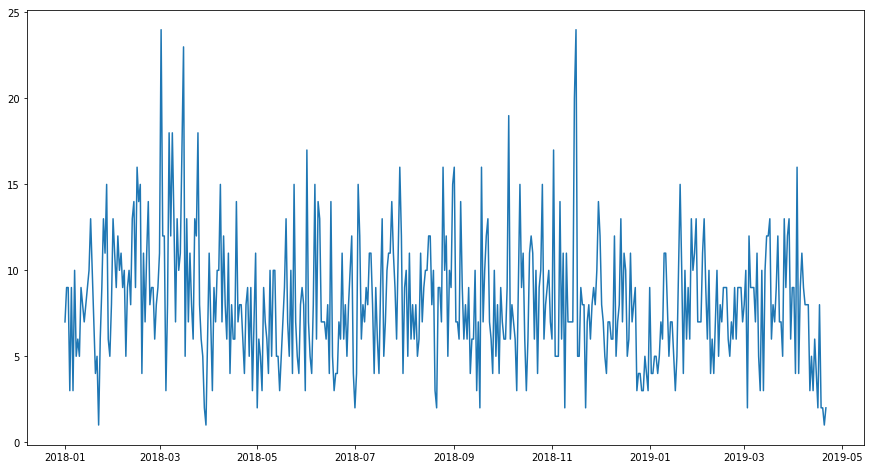

In [7]:
plt.figure(figsize=(15,8))
plt.plot(data.loc[data.Neighborhood==1].Date,data.loc[data.Neighborhood==1].tot_crimes)

In [8]:
data_reshape=data.pivot(index='Neighborhood', columns='Date', values='tot_crimes')
data_reshape=data_reshape.iloc[:-1,:]
data_reshape.fillna(0, inplace=True)
#data_reshape=data_reshape.rolling(180,axis=1).sum()

In [9]:
urns=(data_reshape.rolling(180,axis=1).sum()/data_reshape.rolling(180,axis=1).sum().sum())

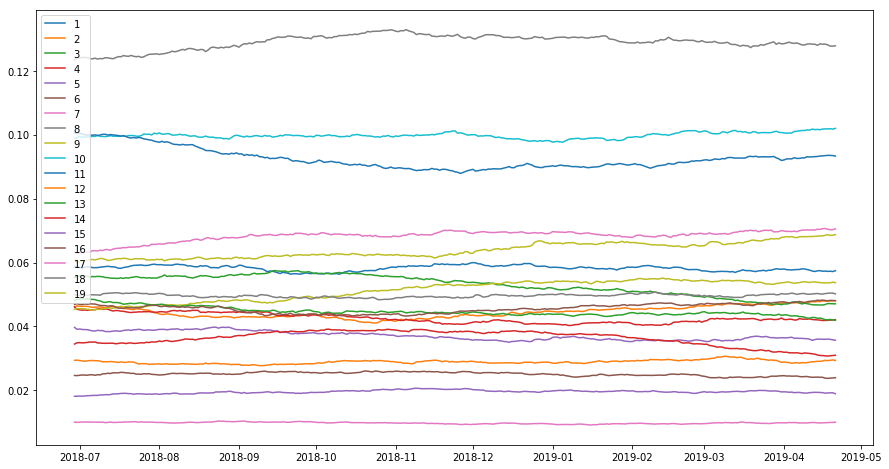

In [10]:
plt.figure(figsize=(15,8))
for i in range(1,20):
    plt.plot(urns.loc[i,end_date:].index, urns.loc[i,end_date:]) 
plt.legend()

In [11]:
data_reshape=data.pivot(index='Neighborhood', columns='Date', values='discovered')
data_reshape=data_reshape.iloc[:-1,:]
data_reshape.fillna(0, inplace=True)
#data_reshape=data_reshape.rolling(180,axis=1).sum()

In [12]:
urns_discovered=(data_reshape.rolling(180,axis=1).sum()/data_reshape.rolling(180,axis=1).sum().sum())

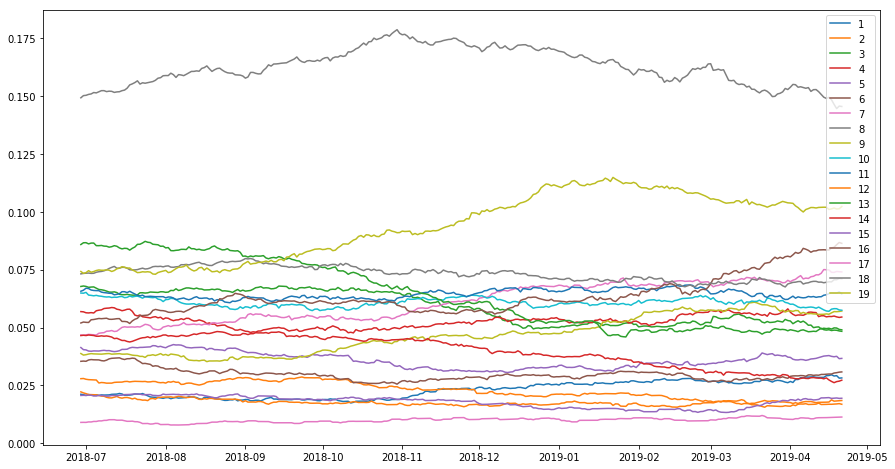

In [13]:
plt.figure(figsize=(15,8))
for i in range(1,20):
    plt.plot(urns_discovered.loc[i,end_date:].index, urns_discovered.loc[i,end_date:]) 
plt.legend()

In [14]:
data_reshape=data.pivot(index='Neighborhood', columns='Date', values='reports')
data_reshape=data_reshape.iloc[:-1,:]
data_reshape.fillna(0, inplace=True)
#data_reshape=data_reshape.rolling(180,axis=1).sum()

In [15]:
urns_reported=(data_reshape.rolling(180,axis=1).sum()/data_reshape.rolling(180,axis=1).sum().sum())

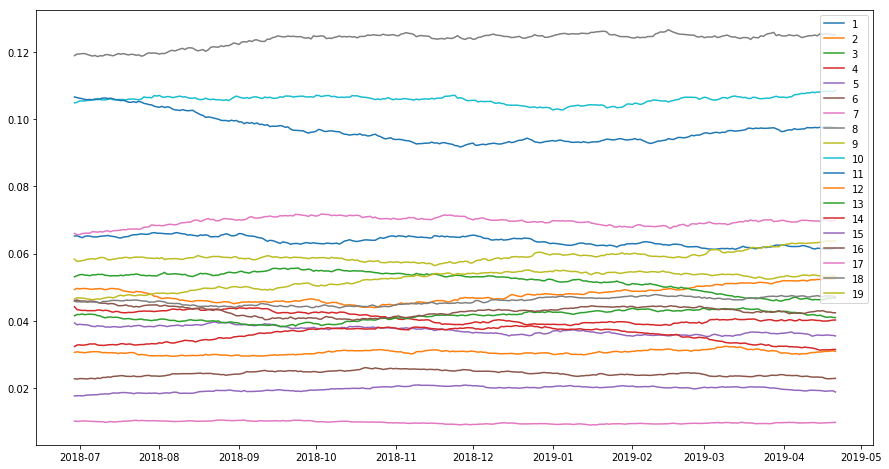

In [16]:
plt.figure(figsize=(15,8))
for i in range(1,20):
    plt.plot(urns_reported.loc[i,end_date:].index, urns_reported.loc[i,end_date:]) 
plt.legend()

#### Reported-Discovered

In [17]:
difference=urns_reported-urns_discovered

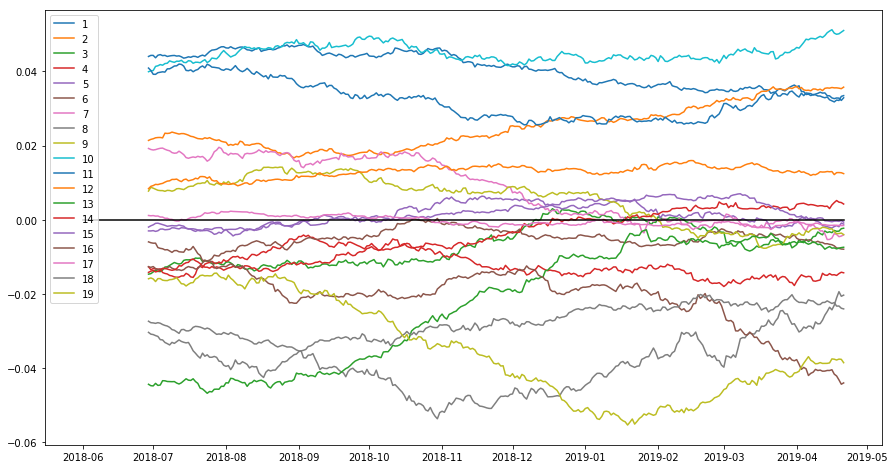

In [18]:
plt.figure(figsize=(15,8))
for i in range(1,20):
    plt.plot(difference.loc[i,end_date:].index, difference.loc[i,end_date:])
plt.plot(difference.loc[1,end_date:].index,[0]*len(difference.loc[1,end_date:]), color='black')
plt.legend()

# Simulation

#### Functions

In [59]:
def add(urn, value, j, col):
    result=urn.iloc[j,col]+10*value
    return(result)
def trial_bernoulli(urn, col):
    proportions=np.array(urn.iloc[:, col]/urn.iloc[:, col].sum())
    rand=[]
    for i in range(len(proportions)):
        rand.append(random.uniform(0,1))
    boolean=[]
    for i in range(len(proportions)):
        boolean.append(rand[i]<proportions[i])
    return(boolean)
def one_t(urn, col):
    for i in range(urn.shape[0]):
        boolean=trial_bernoulli(urn, col)
        if sum(boolean)==urn.shape[0]:
            urn.iloc[i,(col+1)]=add(urn, urn.iloc[i,(col+1)], i, col)
        else:
            urn.iloc[i,(col+1)]=urn.iloc[i,(col)]
    return(urn)

In [71]:
reported=data.pivot(index='Neighborhood', columns='Date', values='discovered')
reported=reported.iloc[:-1,:]
reported.fillna(0, inplace=True)
first=(reported.rolling(60,axis=1).sum()).iloc[:,59:]
reported=reported.iloc[:,179:]
reported.iloc[:,0]=first
reported=reported.loc[[13,14,16],:]

In [72]:
for i in range(reported.shape[1]-1):
    reported=one_t(reported,i)

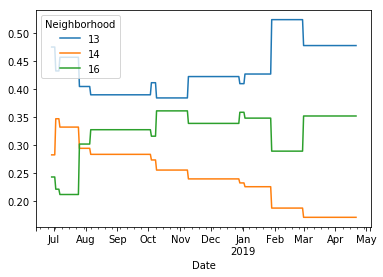

In [73]:
(reported/reported.sum()).T.plot()